# Debugging dask workflows

Specifically a task graph built as part of a projecrt to build a brain-template using the AFNI software. The concepts are generally applicable to debugging Dask  though. This largely draws from the Dask documentation ([link here](http://dask.pydata.org/en/latest/debugging.html)) regarding debugging. There's lots of other approaches to explore not listed here.

### import packages and set up to debug dask in different ways

In [1]:
from pathlib import Path
import pandas as pd
import os
import time
from distutils.spawn import find_executable
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('max_colwidth',500)
from importlib import reload
from IPython.core.debugger import Pdb; ipdb=Pdb()
import subprocess

# Imports for dask
from dask.distributed import Client, LocalCluster
from dask import delayed

# Imports for using AFNI
import afni_python
import afni_python.afni_base as ab
from afni_python import construct_template_graph
from afni_python.regwrap import RegWrap
import sys

In [2]:
analysis_version = "2018_07_12"
project_dir_absolute = Path('/Users/rodgersleejg/Downloads/afni_test')
%pwd
%cd {project_dir_absolute}
%pwd

/Users/rodgersleejg/Downloads/afni_test


'/Users/rodgersleejg/Downloads/afni_test'

## Setup dask cluster

In [3]:

client = Client(processes = False,
    n_workers= 1,
    threads_per_worker=2
    )
# For debugging cluster distributed execution:
# from dask_jobqueue  import SLURMCluster
# cluster = SLURMCluster(
#     queue='nimh',
#     memory =  '8g',
#     processes=1,
#     threads = 8,
#     job_extra = ["--time=36:00:00"]
# )
# client_dist = Client(cluster)

In [4]:
client

Client Scheduler: inproc://137.187.30.241/46877/1 Dashboard: http://localhost:8787/status,Cluster Workers: 1 Cores: 2 Memory: 8.59 GB


## Setup for troubleshooting AFNI pipeline

In [5]:
Path(find_executable('afni'))

PosixPath('/Users/rodgersleejg/abin/afni')

In [6]:
orig_scans  = Path('/Users/rodgersleejg/data/hpc/vbm/bids')
output_dir = project_dir_absolute / 'axialized_scans'
afni_dir = Path('~').expanduser() / 'abin'
if not afni_dir.exists():

        afni_path = Path(find_executable('afni'))
        if not afni_path.exists():
            raise EnvironmentError
        else: 
            afni_dir = afni_path.parent

In [7]:
scans_glob = '**/*T1w.nii.gz'

In [8]:
scans = pd.DataFrame({'scan_path':[p.as_posix() for p in orig_scans.glob(scans_glob)]})

In [9]:
scans.head()


,scan_path
0,/Users/rodgersleejg/data/hpc/vbm/bids/sub-12/ses-02/anat/sub-12_ses-02_acq-fspgr_run-001_T1w.nii.gz
1,/Users/rodgersleejg/data/hpc/vbm/bids/sub-12/ses-02/anat/sub-12_ses-02_acq-fspgr_run-002_T1w.nii.gz
2,/Users/rodgersleejg/data/hpc/vbm/bids/sub-12/ses-03/anat/sub-12_ses-03_acq-fspgr_run-002_T1w.nii.gz
3,/Users/rodgersleejg/data/hpc/vbm/bids/sub-12/ses-03/anat/sub-12_ses-03_acq-fspgr_run-001_T1w.nii.gz
4,/Users/rodgersleejg/data/hpc/vbm/bids/sub-12/ses-01/anat/sub-12_ses-01_acq-fspgr_run-001_T1w.nii.gz


In [10]:
scan_path = scans.scan_path.iloc[0]
scan_path

'/Users/rodgersleejg/data/hpc/vbm/bids/sub-12/ses-02/anat/sub-12_ses-02_acq-fspgr_run-001_T1w.nii.gz'

In [11]:
ab.__file__

'/Users/rodgersleejg/AFNI/src/python_scripts/afni_python/afni_base.py'

In [12]:
# This is a hack because the AFNI regwrap class parses
# input from a system call as part of its initialization
sys.argv = [
    Path(ab.__file__).with_name('make_template_dask.py'),
    '-ok_to_exist',
    '-dsets',
    *list(scans.head().scan_path),
    '-init_base',
    afni_dir / 'MNI152_2009_template.nii.gz',
    '-bokeh_port',
    '8791', ]
# '-dask_mode', 'localcluster'
sys.argv

[PosixPath('/Users/rodgersleejg/AFNI/src/python_scripts/afni_python/make_template_dask.py'),
 '-ok_to_exist',
 '-dsets',
 '/Users/rodgersleejg/data/hpc/vbm/bids/sub-12/ses-02/anat/sub-12_ses-02_acq-fspgr_run-001_T1w.nii.gz',
 '/Users/rodgersleejg/data/hpc/vbm/bids/sub-12/ses-02/anat/sub-12_ses-02_acq-fspgr_run-002_T1w.nii.gz',
 '/Users/rodgersleejg/data/hpc/vbm/bids/sub-12/ses-03/anat/sub-12_ses-03_acq-fspgr_run-002_T1w.nii.gz',
 '/Users/rodgersleejg/data/hpc/vbm/bids/sub-12/ses-03/anat/sub-12_ses-03_acq-fspgr_run-001_T1w.nii.gz',
 '/Users/rodgersleejg/data/hpc/vbm/bids/sub-12/ses-01/anat/sub-12_ses-01_acq-fspgr_run-001_T1w.nii.gz',
 '-init_base',
 PosixPath('/Users/rodgersleejg/abin/MNI152_2009_template.nii.gz'),
 '-bokeh_port',
 '8791']

In [13]:
ps = RegWrap('make_template_dask.py')
ps.init_opts()
rv = ps.get_user_opts('help')
ps.process_input()

#++ Found dset /Users/rodgersleejg/data/hpc/vbm/bids/sub-12/ses-02/anat/sub-12_ses-02_acq-fspgr_run-001_T1w.nii.gz

#++ Found dset /Users/rodgersleejg/data/hpc/vbm/bids/sub-12/ses-02/anat/sub-12_ses-02_acq-fspgr_run-002_T1w.nii.gz

#++ Found dset /Users/rodgersleejg/data/hpc/vbm/bids/sub-12/ses-03/anat/sub-12_ses-03_acq-fspgr_run-002_T1w.nii.gz

#++ Found dset /Users/rodgersleejg/data/hpc/vbm/bids/sub-12/ses-03/anat/sub-12_ses-03_acq-fspgr_run-001_T1w.nii.gz

#++ Found dset /Users/rodgersleejg/data/hpc/vbm/bids/sub-12/ses-01/anat/sub-12_ses-01_acq-fspgr_run-001_T1w.nii.gz

#++ Found initial base dset /Users/rodgersleejg/abin/MNI152_2009_template.nii.gz



## Edit the code base and reload the code 
You can reload modules but not functions. And the behavior can be funny because of the various ways that import works under the hood.

 If you get an error when you are running in your local python interpretter you can always use the debug command with ipython. This breaks down a little for distributed computation... more on this later.

In [14]:
reload(construct_template_graph)
# One can swap out the dask delay function for
# the following to trigger immediate code execution
# in the local process instead of constructing a task graph
# def delayed(fn):
#     return fn
task_graph = ipdb.runcall(construct_template_graph.get_task_graph, ps, delayed)

> /Users/rodgersleejg/AFNI/src/python_scripts/afni_python/construct_template_graph.py(820)get_task_graph()
    818     #     task_graph = get_nl_mean(ps, dsetlist, warpsetlist, delayed)
    819     #     return task_graph
--> 820     dsetlist = ps.dsets.parlist
    821     if ps.warpsets:
    822         warpsetlist = ps.warpsets.parlist

Configured first processing loop
[Delayed('affine_align-a654f5f8-7b25-465b-abac-2cf95b2eb525'), Delayed('affine_align-410866ab-edfc-4275-8b14-4ad6ab4e1b3d'), Delayed('affine_align-bef0fd26-46c0-43c5-ab60-b4fa41452521'), Delayed('affine_align-1ef7fe38-74d3-42c1-a1c0-8f145578e771'), Delayed('affine_align-5243c208-b04c-4dc8-92d5-d72d106dbad3')]
Configured first processing loop
Configured first processing loop


In [31]:
%debug

> /Users/rodgersleejg/AFNI/src/python_scripts/afni_python/construct_template_graph.py(774)get_nl_mean()
    772             warpsetlist,
    773             resize_brain,
--> 774             **kwargs_dict[level])
    775 
    776     # return the mean brain template and the warps

0


### Exploring the task graph

In [36]:
# For taskgraph visualizing:conda install -y python-graphviz

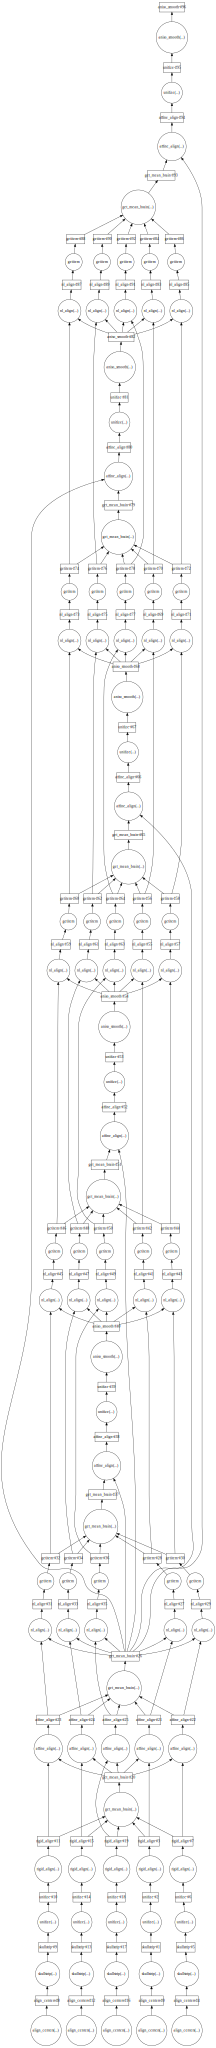

In [15]:
task_graph[0].visualize('task_graph.svg')

## Executing the task graph and assessing the results

In [ ]:
result = client.compute(task_graph)

In [ ]:
The result object will contain the results of the futures that compose the task graph. You can inspect them individually. Their status changes as the task graph is executed:

In [ ]:
pending = [x for x in result if x.status == 'pending']
len(pending)

errored = [x for x in result if x.status == 'error']
len(errored)

finished = [x for x in result if x.status == 'finished']
len(finished)

If you try to gather a result object that had an error you will retrieve the error from the worker. If it is finished you will retrieve the output. If it is pending the python process will be blocked and once the task is finished the output/error message will be displayed

In [78]:
## example from a previous computation, error is purely illustrative
client.gather(result[0])

AssertionError: 

## Debugging errors that were returned from dask workers. 

If you want to debug a problem using pdb it gets a little harder. The dask documentation for debugging is very good and should be read. Here is an example of rerunning a command that failed on a worker. When it fails you can debug it with pdb just like a local failure. Sometimes your local host does not have the resources to do this though... be careful what you try to compute with  your local process.

In [79]:
## example from a previous computation, error is purely illustrative
client.recreate_error_locally(result[0])

cannot find either /gpfs/gsfs10/users/MLDSST/temp_for_pac/axialized_scans/orig_pac_7462/orig_pac_7462_ac_ununifized+orig.BRIK or /gpfs/gsfs10/users/MLDSST/temp_for_pac/axialized_scans/orig_pac_7462/orig_pac_7462_ac+orig.BRIK
Executing:     mv /gpfs/gsfs10/users/MLDSST/temp_for_pac/axialized_scans/orig_pac_7462/orig_pac_7462_ac+orig.BRIK /gpfs/gsfs10/users/MLDSST/temp_for_pac/axialized_scans/orig_pac_7462/orig_pac_7462_ac_ununifized+orig.BRIK;     3dUnifize -prefix /gpfs/gsfs10/users/MLDSST/temp_for_pac/axialized_scans/orig_pac_7462/orig_pac_7462_ac+orig.BRIK /gpfs/gsfs10/users/MLDSST/temp_for_pac/axialized_scans/orig_pac_7462/orig_pac_7462_ac_ununifized+orig.BRIK     in /gpfs/gsfs10/users/MLDSST/temp_for_pac/axialized_scans/orig_pac_7462/
cannot find either /gpfs/gsfs10/users/MLDSST/temp_for_pac/axialized_scans/orig_pac_7462/orig_pac_7462_ac_ununifized+orig.BRIK or /gpfs/gsfs10/users/MLDSST/temp_for_pac/axialized_scans/orig_pac_7462/orig_pac_7462_ac+orig.BRIK
** ERROR: Could not unifiz

AssertionError: 

In [74]:
## example from a previous computation, error is purely illustrative
%debug

> <ipython-input-69-0ffb5b711c79>(36)unifize()
     34         if (not o_exists and not ps.dry_run()):
     35             print("** ERROR: Could not unifize with \n  %s\n" % cmd_str)
---> 36             assert False
     37             return None
     38     else:

'    mv /gpfs/gsfs10/users/MLDSST/temp_for_pac/axialized_scans/orig_pac_7462/orig_pac_7462_ac+orig.BRIK /gpfs/gsfs10/users/MLDSST/temp_for_pac/axialized_scans/orig_pac_7462/orig_pac_7462_ac_ununifized+orig.BRIK;     3dUnifize -prefix /gpfs/gsfs10/users/MLDSST/temp_for_pac/axialized_scans/orig_pac_7462/orig_pac_7462_ac+orig.BRIK /gpfs/gsfs10/users/MLDSST/temp_for_pac/axialized_scans/orig_pac_7462/orig_pac_7462_ac_ununifized+orig.BRIK    '
